In [1]:
import boto3 
import time
from datetime import datetime, timedelta
import numpy as np
import tiledb
import os

from dask.distributed import Client
from dask.distributed import LocalCluster
import dask, dask.array
from dask_gateway import Gateway

import matplotlib.pyplot as plt

import requests
from pathlib import Path
 
from earthscope_sdk.auth.device_code_flow import DeviceCodeFlowSimple
from earthscope_sdk.auth.auth_flow import NoTokensError

def unix_time_millis(dt):
    epoch = datetime.utcfromtimestamp(0)
    return int((dt - epoch).total_seconds() * 1e3)

def utc_time(dt):
    epoch = datetime.utcfromtimestamp(0)
    return timedelta(seconds=dt*1e-3) + epoch

def get_es_file(url, directory_to_save_file='./', token_path='./'):
    """function to get earthscope data using es-sdk
    modified from https://gitlab.com/earthscope/public/earthscope-sdk

    Parameters
    ----------
    url : string
        url of desired file at gage-data.earthscope.org
    directory_to_save_file : str, optional
        path of directory in which to save the file, by default cwd
    token_path : str, optional
        path of directory in which to save the token, by default './'
    """
    # instantiate the device code flow subclass
    device_flow = DeviceCodeFlowSimple(Path(token_path))
    try:
      # get access token from local path
      device_flow.get_access_token_refresh_if_necessary()
    except NoTokensError:
      # if no token was found locally, do the device code flow
      device_flow.do_flow()
    token = device_flow.access_token

    # request a file and provide the token in the Authorization header
    file_name = Path(url).name

    r = requests.get(url, headers={"authorization": f"Bearer {token}"})
    if r.status_code == requests.codes.ok:
      # save the file
      with open(Path(Path(directory_to_save_file) / file_name), 'wb') as f:
          for data in r:
              f.write(data)
    else:
      #problem occured
      print(f"failure: {r.status_code}, {r.reason}")

ImportError: cannot import name 'DeviceCodeFlowSimple' from 'earthscope_sdk.auth.device_code_flow' (/srv/conda/envs/notebook/lib/python3.12/site-packages/earthscope_sdk/auth/device_code_flow.py)

In [3]:
import georinex as gr #https://github.com/geospace-code/georinex/blob/main/Readme_OBS.md
import os


In [4]:
!aws sso login --profile es-dev

Attempting to automatically open the SSO authorization page in your default browser.
If the browser does not open or you wish to use a different device to authorize this request, open the following URL:

https://d-9a672d0f17.awsapps.com/start/#/device

Then enter the code:

PXZN-KFFT
Successfully logged into Start URL: https://d-9a672d0f17.awsapps.com/start#/


In [5]:
session=boto3.Session(profile_name='es-dev')
credentials=session.get_credentials()
credentials=credentials.get_frozen_credentials()

tdb_config={"vfs.s3.region": "us-east-2", "sm.io_concurrency_level": 12, 
                                              "vfs.s3.aws_access_key_id":credentials.access_key, "vfs.s3.aws_secret_access_key":credentials.secret_key,
                                             "vfs.s3.aws_session_token":credentials.token}

In [6]:
# pnum='P057'  #using datasources-api https://datasources-api.dev.earthscope.org/docs#/Stream/Stream-find_streams
# edid="01GVDXYKWXCFP2N5WAJN4CX36F"
# year=2024
# start_time='2024-05-11'
# duration='12' #hours  
# constell= 0 #'GPS'
# obs_code=12611 #L1C   int(12611).to_bytes(2, 'big').decode("utf-8")

# bucket='s3://repository-stage-us-east-2-mlmoghi3ooss/gnss/obs/tiledb/'

pnum = 'P057'  
edid = "01GVDXYKWXCFP2N5WAJN4CX36F"
year = 2024
start_time = '2024-05-11'
duration = '12'  # hours  
constell = 0  # 'GPS'
obs_code = 12611  # 1C  
# Convert the observation code to a byte string representation (e.g., '12611' -> b'12611')
obs_code_str = int(obs_code).to_bytes(2, 'big').decode("utf-8")


bucket = 's3://repository-stage-us-east-2-mlmoghi3ooss/geolab-gnss-demo/'

uri=bucket+pnum+".tdb"

start_date=datetime.fromisoformat(start_time)
durationz=timedelta(hours=int(duration)) #1hour
end_date=start_date+durationz



In [7]:
%%time
# With pandas
import pandas as pd
df = pd.DataFrame()

# Print the values to verify
print(f"URI: {uri}")
print(f"Start Date: {start_date}")
print(f"End Date: {end_date}")
print(f"Constellation: {constell}")
print(f"Obscode: {obs_code}")

start = unix_time_millis(start_date)
end = unix_time_millis(end_date)

with tiledb.open(uri, mode="r", config=tdb_config,) as A:
    # A.upgrade_version()
    # note that array indexes are half-open like NumPy
    # df = A.df[unix_time_millis(start_date): unix_time_millis(end_date),constell,:,obs_code]
    df = A.df[start:end, :]

    # schema = A.schema
    # print(schema)

    print("Count in entire array for 'snr':", A.query().agg({"snr": "count"})[:])
df["constell"] = constell
df["obs_code"] = obs_code
df.head()

URI: s3://repository-stage-us-east-2-mlmoghi3ooss/geolab-gnss-demo/P057.tdb
Start Date: 2024-05-11 00:00:00
End Date: 2024-05-11 12:00:00
Constellation: 0
Obscode: 12611
Count in entire array for 'snr': 414257029
CPU times: user 7.11 s, sys: 4.09 s, total: 11.2 s
Wall time: 5.81 s


,time,sys,sat,obs,range,phase,doppler,snr,slip,flags,fcn,constell,obs_code
0,1715393175000,1,2,12611,2.598896e+07,1.365729e+08,3239.104,34.00,0,1,0,0,12611
1,1715393190000,1,2,12611,2.597972e+07,1.365243e+08,3238.862,30.50,0,0,0,0,12611
2,1715393205000,1,2,12611,2.597047e+07,1.364757e+08,3239.710,39.50,0,1,0,0,12611
3,1715393220000,1,2,12611,2.596122e+07,1.364271e+08,3239.520,38.50,0,0,0,0,12611
4,1715393235000,1,2,12611,2.595198e+07,1.363786e+08,3238.626,36.75,0,1,0,0,12611


In [8]:
print(df.shape)
df.head()


(514811, 13)


,time,sys,sat,obs,range,phase,doppler,snr,slip,flags,fcn,constell,obs_code
0,1715393175000,1,2,12611,2.598896e+07,1.365729e+08,3239.104,34.00,0,1,0,0,12611
1,1715393190000,1,2,12611,2.597972e+07,1.365243e+08,3238.862,30.50,0,0,0,0,12611
2,1715393205000,1,2,12611,2.597047e+07,1.364757e+08,3239.710,39.50,0,1,0,0,12611
3,1715393220000,1,2,12611,2.596122e+07,1.364271e+08,3239.520,38.50,0,0,0,0,12611
4,1715393235000,1,2,12611,2.595198e+07,1.363786e+08,3238.626,36.75,0,1,0,0,12611


<Axes: >

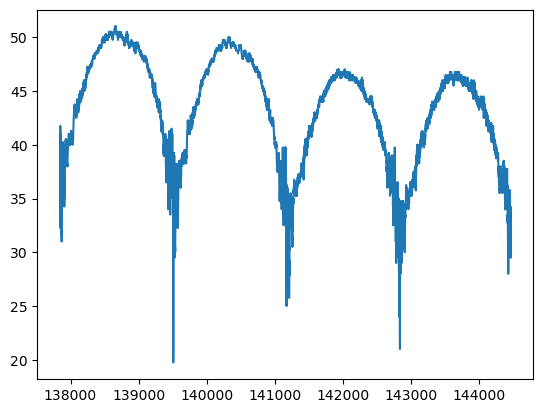

In [12]:
df[df.sat==1].snr.plot()

# Dask

In [8]:
from dask.distributed import Client
from dask.distributed import LocalCluster
import dask, dask.array
from dask_gateway import Gateway
import bokeh

gateway = Gateway()  # Uses values configured for the 2i2c Dask hub (recommended)

gateway.list_clusters()

options = gateway.cluster_options()
# options.worker_cores = 2
options

Task exception was never retrieved
future: <Task finished name='Task-898' coro=<Client._gather.<locals>.wait() done, defined at /srv/conda/envs/notebook/lib/python3.11/site-packages/distributed/client.py:2197> exception=AllExit()>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/distributed/client.py", line 2206, in wait
    raise AllExit()
distributed.client.AllExit
Exception in callback None()
handle: <Handle cancelled>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/tornado/iostream.py", line 1367, in _do_ssl_handshake
    self.socket.do_handshake()
  File "/srv/conda/envs/notebook/lib/python3.11/ssl.py", line 1382, in do_handshake
    self._sslobj.do_handshake()
ssl.SSLCertVerificationError: [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate (_ssl.c:1006)

During handling of the above exception, another exception occurred:

Traceback (most recent call la

In [9]:
# Create and scale gateway cluster
cluster = gateway.new_cluster(options)
cluster.scale(2)
cluster.adapt(minimum=2, maximum=4)
cluster


In [11]:
#Connect to the gateway cluster
client = cluster.get_client()
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.9c004566d8944ad8bd0efa8a89231b8a/status,


2025-04-30 03:38:47,039 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


In [12]:
import dask.array as da
a = da.random.normal(size=(1000, 1000), chunks=(500, 500))
a.mean().compute()

KeyboardInterrupt: 

In [31]:
import dask_ml.datasets
import dask_ml.cluster
import matplotlib.pyplot as plt


In [32]:
X, y = dask_ml.datasets.make_blobs(n_samples=10000000,
                                   chunks=1000000,
                                   random_state=0,
                                   centers=3,)
X = X.persist()
X

dask.array<concatenate, shape=(10000000, 2), dtype=float64, chunksize=(1000000, 2), chunktype=numpy.ndarray>

In [33]:
km = dask_ml.cluster.KMeans(n_clusters=3, init_max_iter=2, oversampling_factor=10)
km.fit(X)

CancelledError: ('any-aggregate-7afa79d34a0042e356e08ad7c9910c51',)

In [ ]:
fig, ax = plt.subplots()
ax.scatter(X[::10000, 0], X[::10000, 1], marker='.', c=km.labels_[::10000],
           cmap='viridis', alpha=0.25);


In [27]:
cluster.close()